Установка необходимых инструментов, если требуется. В моем случае необходимо установить faker.

In [56]:
!pip install faker

Импорт инструментов, необходимых для решения задач.

In [57]:
import pandas as pd
import numpy as np
from faker import Faker
import random
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor
from scipy import stats

#Исходный датасет

Вам необходимо сгенерировать свой датасет или выбрать любой публичный датасет
имеющий

● не менее 100 млн записей. Если не получается сделать расчеты на таком объеме -
можно уменьшить размер.

● имеющий колонки различных типов данных - numeric, datetime (range в несколько
лет), string.

● достаточно минимального набора колонок, чтобы датафайл был не сильно
большой.

● имеющий не менее 10% дублей (допускается добавить их самостоятельно)

● хранящийся в csv / json формате в файле на диске или по url

In [58]:

faker = Faker()
num_records = 1000000 # Количество строк
duplicate_rate = 0.15 # Процент дубликатов
numeric_ratio = 0.3  # Процент строк с цифрами

# Генерация данных
data = []
for _ in range(num_records):
    record = {
        'numeric': random.randint(0, 1000),
        'datetime': faker.date_time_between(start_date='-4y', end_date='now'),
        'string': faker.word() if random.random() > numeric_ratio else faker.word() + str(random.randint(0, 9))
    }
    data.append(record)

# Добавление дублей
num_duplicates = int(num_records * duplicate_rate)
duplicates = random.sample(data, num_duplicates)
data.extend(duplicates)

# Преобразование в DataFrame и сохранение
df = pd.DataFrame(data)
df.to_csv('dataset.csv', index=False)
df

,numeric,datetime,string
0,777,2022-11-03 12:32:46.958561,cover
1,200,2021-05-29 15:25:18.791190,beautiful
2,736,2020-09-14 18:57:27.665770,red
3,454,2022-11-01 18:42:49.781667,apply
4,640,2020-12-30 17:02:42.044359,guess
...,...,...,...
1149995,781,2024-02-14 19:59:52.407068,officer
1149996,294,2021-07-22 04:05:42.792057,share
1149997,868,2024-04-12 05:47:53.846558,few
1149998,116,2021-02-25 14:57:02.850778,good8


#Считывание и процессинг

Считываем файл или тянем данные по ссылке и далее процессим данные

● удалить пустые / na строки

● удалить дубли

● строки в которых нет цифр превратить в пустые

удалить записи в промежутке от 1 до 3 часов ночи

Для ускорения выполнения распараллеливайте выполнение этих шагов

In [59]:

# Функция для считывания и обработки данных
def read_and_process(file_path):
    df = pd.read_csv(file_path)
    return df

# Функция для удаления пустых / na строк
def remove_na(df):
    return df.dropna()

# Функция для удаления дублей
def remove_duplicates(df):
    return df.drop_duplicates()

# Функция для замены строк без цифр на пустые
def replace_non_numeric(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x if any(char.isdigit() for char in str(x)) else '')
    return df

# Функция для удаления записей с 1 до 3 часов ночи
def remove_night_records(df, col_name):
    df[col_name] = pd.to_datetime(df[col_name])
    df = df[(df[col_name].dt.hour < 1) | (df[col_name].dt.hour >= 3)]
    return df

# Считывание и обработка данных в параллельном режиме
with ThreadPoolExecutor(max_workers=4) as executor:
    future = executor.submit(read_and_process, 'dataset.csv')
    df = future.result()
    df = remove_na(df)
    df = remove_duplicates(df)
    df = replace_non_numeric(df, 'string')
    df = remove_night_records(df, 'datetime')

# Сохранение обработанного файла
df.to_csv('processed_dataset.csv', index=False)

df

,numeric,datetime,string
0,777,2022-11-03 12:32:46.958561,
1,200,2021-05-29 15:25:18.791190,
2,736,2020-09-14 18:57:27.665770,
3,454,2022-11-01 18:42:49.781667,
4,640,2020-12-30 17:02:42.044359,
...,...,...,...
999994,74,2021-04-11 04:12:59.311416,
999995,514,2023-05-11 20:34:59.171199,event2
999997,659,2024-03-07 00:18:29.720978,
999998,646,2022-01-08 15:01:04.849634,


#Расчет метрик

Агрегация по времени, для каждого часа рассчитать

● кол-во уникальных string

● среднее и медиану для numeric

Так же напишите SQL запрос для выполнения подобных расчетов напрямую в базе
данных. Можно его вставить в код в виде комментария.

In [60]:
# Функция для расчета метрик
def calculate_metrics(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['hour'] = df['datetime'].dt.hour

    agg_metrics = df.groupby('hour').agg({
        'string': lambda x: x.nunique(),
        'numeric': ['mean', 'median']
    })

    agg_metrics.columns = ['unique_strings', 'numeric_mean', 'numeric_median']
    return agg_metrics.reset_index()

# Расчет метрик
metrics = calculate_metrics(df)
print(metrics)

# SQL запрос для выполнения расчетов в базе данных
sql_query = """
SELECT
    EXTRACT(HOUR FROM datetime) AS hour,
    COUNT(DISTINCT string) AS unique_strings,
    AVG(numeric) AS numeric_mean,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY numeric) AS numeric_median
FROM dataset
GROUP BY EXTRACT(HOUR FROM datetime)
"""
print(sql_query)


    hour  unique_strings  numeric_mean  numeric_median
0      0            7059    502.501375           503.0
1      3            7166    500.484136           499.0
2      4            6997    500.445377           502.0
3      5            7042    502.794458           505.0
4      6            7059    499.245573           499.0
5      7            7029    497.645927           494.0
6      8            7137    500.733380           502.0
7      9            7081    501.191433           502.0
8     10            7019    502.913361           505.0
9     11            7070    500.723679           501.0
10    12            6974    498.749825           499.0
11    13            7107    497.123766           493.0
12    14            7093    501.539015           501.0
13    15            7055    497.429188           498.0
14    16            7112    499.711334           500.0
15    17            7114    501.555799           502.0
16    18            7086    499.937232           501.0
17    19  

#Мерж с метриками

К каждой строке в исходном датасете примержить метрики ближайшего часа
рассчитанные в предыдущем шаге

In [61]:
# Функция для мержа метрик
def merge_metrics(df, metrics):
    df['hour'] = df['datetime'].dt.hour
    df = pd.merge(df, metrics, on='hour', how='left')
    return df

# Мерж
df = merge_metrics(df, metrics)
print(df.head())

# Сохранение результата
df.to_csv('merged_dataset.csv', index=False)


   numeric                   datetime string  hour  unique_strings  \
0      777 2022-11-03 12:32:46.958561           12            6974   
1      200 2021-05-29 15:25:18.791190           15            7055   
2      736 2020-09-14 18:57:27.665770           18            7086   
3      454 2022-11-01 18:42:49.781667           18            7086   
4      640 2020-12-30 17:02:42.044359           17            7114   

   numeric_mean  numeric_median  
0    498.749825           499.0  
1    497.429188           498.0  
2    499.937232           501.0  
3    499.937232           501.0  
4    501.555799           502.0  


#Аналитические метрики

Для колонки numeric по полному датасету построить

● Гистограмму

● 95% доверительный интервал, с комментарием как выбирали методику расчета

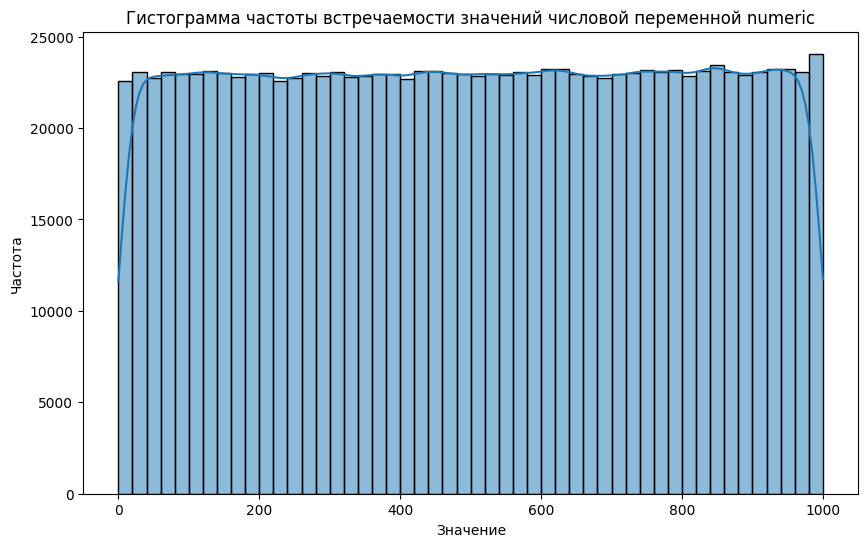

95% Доверительный интервал: (500.32313408181176, 501.37958765731867)


In [62]:
# Считывание исходного датасета
ddf = pd.read_csv('dataset.csv', parse_dates=['datetime'])

# Гистограмма
plt.figure(figsize=(10, 6))
sns.histplot(ddf['numeric'], bins=50, kde=True)
plt.title('Гистограмма частоты встречаемости значений числовой переменной numeric')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.show()

# 95% доверительный интервал
mean = ddf['numeric'].mean()
std_dev = ddf['numeric'].std()
sample_size = len(ddf['numeric'])
confidence_interval = stats.norm.interval(0.95, loc=mean, scale=std_dev / sample_size**0.5)
print(f'95% Доверительный интервал: {confidence_interval}')

#Визуализация

1. Отрисовать график среднего значения numeric колонки (y) по месяцам (x).

2. Heatmap по частотности символов в колонке string

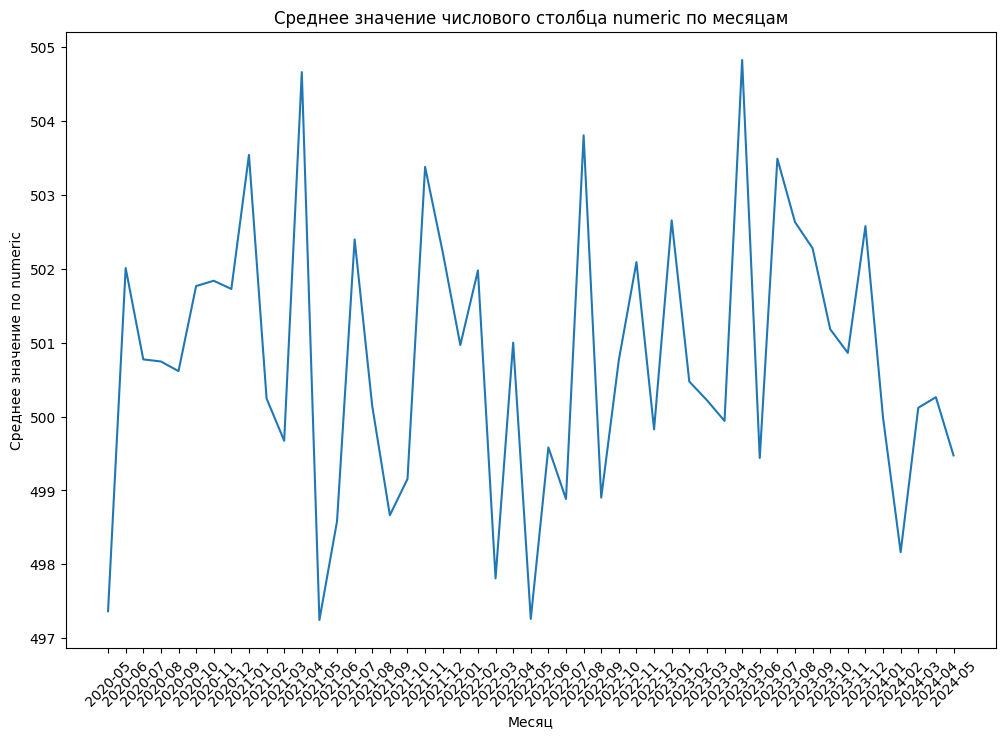

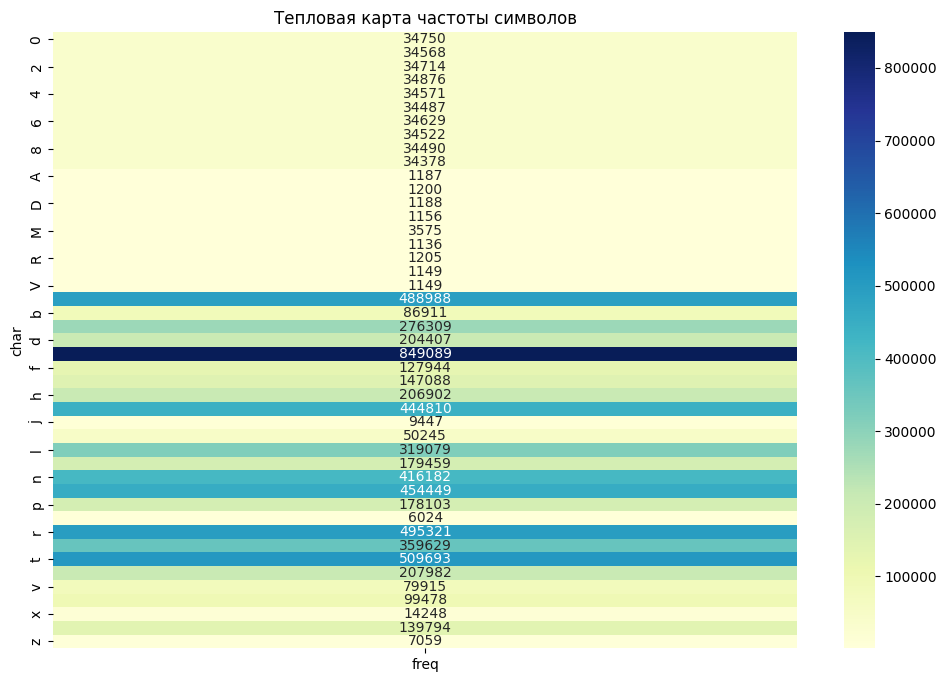

In [63]:
# Среднее значение по месяцам
ddf['month'] = ddf['datetime'].dt.to_period('M')
monthly_mean = ddf.groupby('month')['numeric'].mean().reset_index()

plt.figure(figsize=(12, 8))
plt.plot(monthly_mean['month'].astype(str), monthly_mean['numeric'])
plt.xlabel('Месяц')
plt.ylabel('Среднее значение по numeric')
plt.title('Среднее значение числового столбца numeric по месяцам')
plt.xticks(rotation=45)
plt.show()

# Разбиение каждой строки на отдельные символы и разворачивание их
string_char_freq = ddf['string'].apply(list).explode().value_counts().reset_index()
string_char_freq.columns = ['char', 'freq']

# Создание pivot table для частотности символов
pivot = string_char_freq.pivot_table(index='char', values='freq', aggfunc='sum')

# Создание тепловой карты
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt="d", cmap='YlGnBu')
plt.title('Тепловая карта частоты символов')
plt.show()


#Доп задание

1. Случайно поделить датасет на 3 части - в одной 25% записей, во второй 25% и
50% в третьей.

2. Проверить на статистическую значимость различий для среднего по колонке
numeric
3. Оценить силу эффекта
4. Проделать шаги 2 и 3 используя баесовский подход
5. Кратко описать как выбирали методы расчета

In [64]:
# Разделение на 3 части
df_part1 = ddf.sample(frac=0.25, random_state=1)
df_part2 = ddf.drop(df_part1.index).sample(frac=0.5, random_state=1)
df_part3 = ddf.drop(df_part1.index).drop(df_part2.index)

# Сохранение частей
df_part1.to_csv('part1.csv', index=False)
df_part2.to_csv('part2.csv', index=False)
df_part3.to_csv('part3.csv', index=False)

# Средние значения
mean1 = df_part1['numeric'].mean()
mean2 = df_part2['numeric'].mean()
mean3 = df_part3['numeric'].mean()

# Тест на значимость различий
t_stat, p_val = stats.ttest_ind(df_part1['numeric'], df_part2['numeric'])
print(f'T-тест между part1 и part2: t={t_stat}, p={p_val}')

# Сила эффекта
effect_size = (mean1 - mean2) / np.sqrt((df_part1['numeric'].std()**2 + df_part2['numeric'].std()**2) / 2)
print(f'Сила эффекта: {effect_size}')



T-тест между part1 и part2: t=1.492474511095833, p=0.13557523332528884
Сила эффекта: 0.0035934586460326947


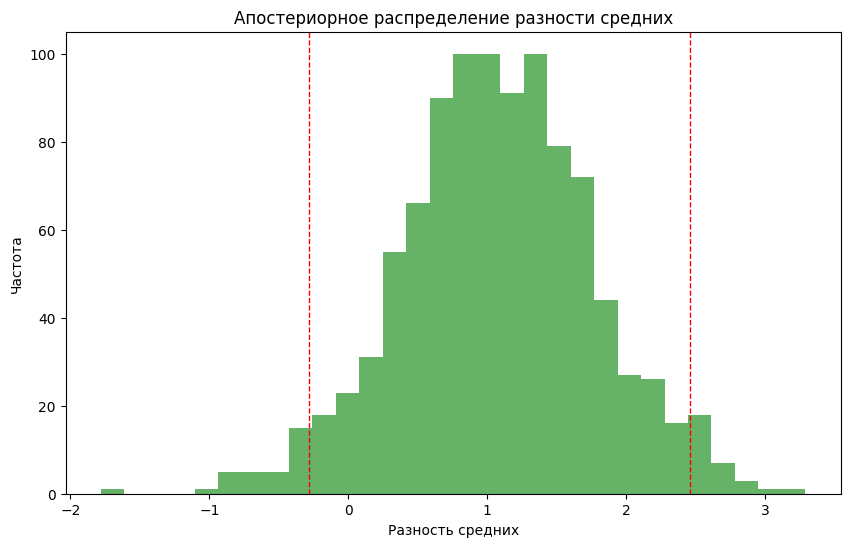

95% Доверительный интервал: [-0.2825252753623019, 2.460373652173932]


In [65]:
# Бутстрэппинг
def bootstrap(data, num_samples):
    n = len(data)
    samples = np.random.choice(data, (num_samples, n), replace=True)
    return np.mean(samples, axis=1)

# Генерация бутстрэппинговых выборок
num_samples = 1000
bootstrap_means1 = bootstrap(df_part1['numeric'].values, num_samples)
bootstrap_means2 = bootstrap(df_part2['numeric'].values, num_samples)

# Разность средних
diff_means = bootstrap_means1 - bootstrap_means2

# Построение постериорного распределения
plt.figure(figsize=(10, 6))
plt.hist(diff_means, bins=30, alpha=0.6, color='g')
plt.axvline(x=np.percentile(diff_means, 2.5), color='red', linestyle='dashed', linewidth=1)
plt.axvline(x=np.percentile(diff_means, 97.5), color='red', linestyle='dashed', linewidth=1)
plt.title('Апостериорное распределение разности средних')
plt.xlabel('Разность средних')
plt.ylabel('Частота')
plt.show()

# Вывод 95% доверительного интервала
ci_lower = np.percentile(diff_means, 2.5)
ci_upper = np.percentile(diff_means, 97.5)
print(f'95% Доверительный интервал: [{ci_lower}, {ci_upper}]')


#Доп. задание 2
Вводные
1. Известно что компания конкурент выпустила 1000 прототипов игр, из которых было
5 успешных.
2. Наша компания выпустила 200 прототипов из которых ни один не был успешен.
Какова вероятность что следующий (201й) наш прототип будет успешен? Какими
методами можно решать данную задачу? Предложите как минимум 2 варианта. Если у
вас есть какой-то вариант решения задачи для которого требуются доп. данные -
перечислите что требуется и метод решения.

Оценка вероятности успеха следующего (201-го) прототипа: 0.00495


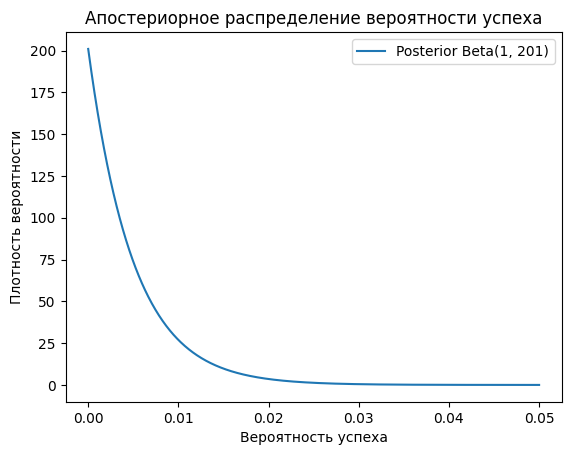

In [66]:
# Данные
alpha_prior = 1  # параметр α априорного распределения Beta(α, β)
beta_prior = 1   # параметр β априорного распределения Beta(α, β)
n_trials = 200   # количество прототипов нашей компании
n_successes = 0  # количество успешных прототипов нашей компании

# Обновление априорного распределения на основе данных
alpha_posterior = alpha_prior + n_successes
beta_posterior = beta_prior + n_trials - n_successes

# Оценка вероятности успеха следующего прототипа
expected_probability = alpha_posterior / (alpha_posterior + beta_posterior)

# Вывод результата
print(f"Оценка вероятности успеха следующего (201-го) прототипа: {expected_probability:.5f}")

# Для визуализации апостериорного распределения
x = np.linspace(0, 0.05, 1000)
y = stats.beta.pdf(x, alpha_posterior, beta_posterior)

plt.plot(x, y, label=f'Posterior Beta({alpha_posterior}, {beta_posterior})')
plt.xlabel('Вероятность успеха')
plt.ylabel('Плотность вероятности')
plt.title('Апостериорное распределение вероятности успеха')
plt.legend()
plt.show()
